In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import mannwhitneyu
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import warnings
import re
warnings.filterwarnings('ignore')
%matplotlib inline

In [24]:
df = pd.read_csv("genes/combined-gene-on-off.csv")
df_motif = df[~df['TATA +'].isnull()]
df.head(1)

,gene,off-period,on-period,off-mean,on-mean,K-off-rate,K-on-rate,off-median,on-median,off-period-counts,on-period-counts,TATA_group,inr_group,chr_x,strand_x,TSS,geneID,TATA +,YY1 +,SP +,SP -,ETS +,ETS -,NFY +,NFY -,CREB +,CREB -,NRF1 +,NRF1 -,ZNF143 +,ZNF143 -,U1 snRNP +,chr_y,start,end,strand_y,gene_id,transcript_id,distance2tss,celltype,H3K27me3_tss,cluster,gene_type,comment
0,LUZP1,"[213, 55, 11, 40]","[7, 7, 2]",79.75,5.333333,0.1875,0.012539,47.5,7.0,4,3,without_TATA,without_inr,chr1,-,23178121.0,ENSG00000169641.9,0.009,0.011,-0.126,-0.16,-0.028,-0.07,0.045,0.065,0.498,0.435,-0.004,0.001,-0.001,-0.067,0.186,chr1,23084023.0,23177808.0,-,ENSG00000169641,NaN,313.0,HBEC,0.0,cluster0,simple,NaN


In [3]:
df.shape

(95, 44)

In [4]:
df_off = pd.DataFrame(columns=['gene', 'celltype', 'off-period'])
for index, row in df.iterrows():
    gene = row['gene']
    celltype = row['celltype']

    # Extract off-period values from the string
    off_periods = [int(period) for period in re.findall(r'\d+', row['off-period'])]
    
    # Append each off-period to the new DataFrame
    for off_period in off_periods:
        if off_period >= 2:
            df_off = df_off.append({'gene': gene, 'celltype': celltype, 'off-period': off_period}, ignore_index=True)


df_off['off-period'] = df_off['off-period'].astype(int)
df_off = pd.merge(df_off, df.drop('off-period', axis=1), on=["gene", "celltype"])
df_off.shape

(7415, 44)

In [5]:
df_off.celltype.value_counts()

HBEC    5347
H9D3    1303
H9D0     765
Name: celltype, dtype: int64

In [6]:
df_off.head(1)

,gene,celltype,off-period,on-period,off-mean,on-mean,K-off-rate,K-on-rate,off-median,on-median,off-period-counts,on-period-counts,TATA_group,inr_group,chr_x,strand_x,TSS,geneID,TATA +,YY1 +,SP +,SP -,ETS +,ETS -,NFY +,NFY -,CREB +,CREB -,NRF1 +,NRF1 -,ZNF143 +,ZNF143 -,U1 snRNP +,chr_y,start,end,strand_y,gene_id,transcript_id,distance2tss,H3K27me3_tss,cluster,gene_type,comment
0,LUZP1,HBEC,213,"[7, 7, 2]",79.75,5.333333,0.1875,0.012539,47.5,7.0,4,3,without_TATA,without_inr,chr1,-,23178121.0,ENSG00000169641.9,0.009,0.011,-0.126,-0.16,-0.028,-0.07,0.045,0.065,0.498,0.435,-0.004,0.001,-0.001,-0.067,0.186,chr1,23084023.0,23177808.0,-,ENSG00000169641,NaN,313.0,0.0,cluster0,simple,NaN


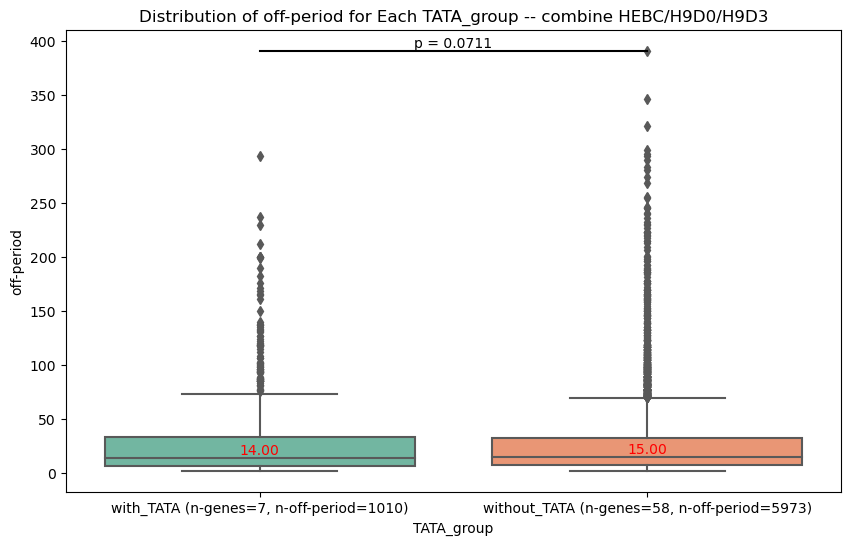

In [8]:
def plot_tata(data,  title, col = 'off-period'):
    
    order = ['with_TATA', 'without_TATA']

#     plt.figure(figsize=(10, 6))
#     sns.violinplot(x="TATA_group", y=col, data=data, palette="Set2", order=order)
#     sns.stripplot(x="TATA_group", y=col, data=data, color='black', size=3, jitter=True, order=order)

#     plt.title(title)
#     plt.ylabel(col)
#     plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x="TATA_group", y=col, data=data, palette="Set2", order=order)
    plt.title(title )
    plt.ylabel(col);
    mean_values = data.groupby('TATA_group')[col].median()
    gene_counts = data.groupby('TATA_group')['gene'].nunique()
    off_period_counts = data.groupby('TATA_group').size()
    new_labels = [f'{o} (n-genes={gene_counts[o]}, n-off-period={off_period_counts[o]})' for o in order]
    plt.xticks(ticks=range(len(new_labels)), labels=new_labels)
    for i, label in enumerate(order):
        plt.text(i, mean_values[label], f'{mean_values[label]:.2f}', ha='center', va='bottom', color='red')

    d1 = data[data['TATA_group'] == 'with_TATA'][col]
    d2 = data[data['TATA_group'] == 'without_TATA'][col]
    stat, p = mannwhitneyu(d1, d2)
    # Annotate plot with the significance level
    x1, x2 = 0, 1  # x coordinates for the two categories you're comparing
    y, h, color = data[col].max() , 1, 'k'  # y position and height for the line, and color
    plt.plot([x1, x2], [y, y], lw=1.5, c=color)
    plt.text((x1+x2)*.5, y,  f'p = {p:.3e}' if p < 0.05 else f'p = {p:.4f}', ha='center', va='bottom', color=color)

    plt.show()
    
data = df_off[df_off["TATA_group"] != "unknown"]
plot_tata(data, f'Distribution of off-period for Each TATA_group -- combine HEBC/H9D0/H9D3')
# plot_tata(data[data.celltype=="HBEC"], f'Distribution of off-period for Each TATA_group -- HEBC')
# plot_tata(data[data.celltype=="H9D0"], f'Distribution of off-period for Each TATA_group -- H9D0')
# plot_tata(data[data.celltype=="H9D3"], f'Distribution of off-period for Each TATA_group -- H9D3')
# plot_tata(data[data.celltype!="HBEC"], f'Distribution of off-period for Each TATA_group -- combine H9D0/H9D3')

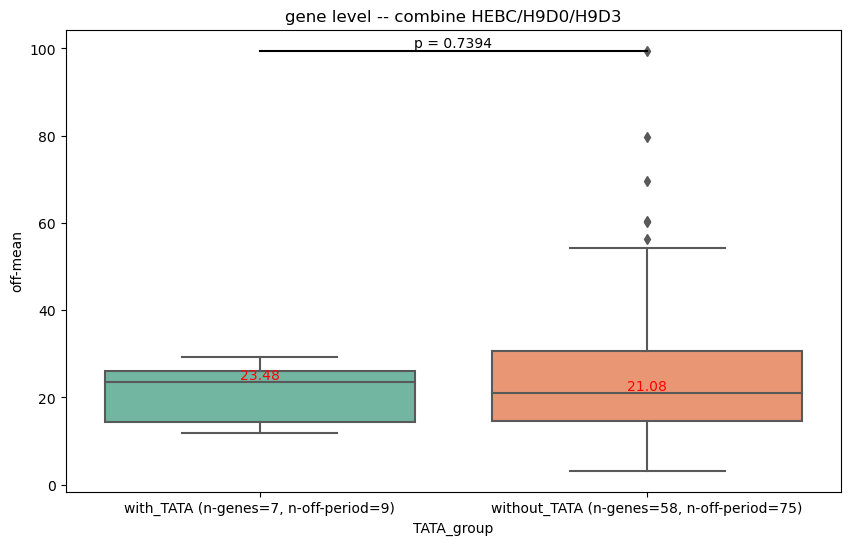

In [9]:
plot_tata(df, f'gene level -- combine HEBC/H9D0/H9D3', col = 'off-mean')

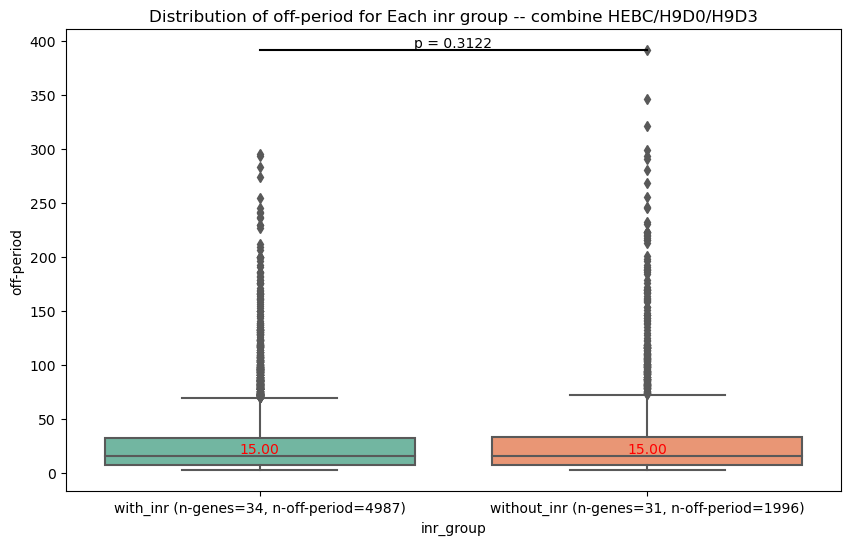

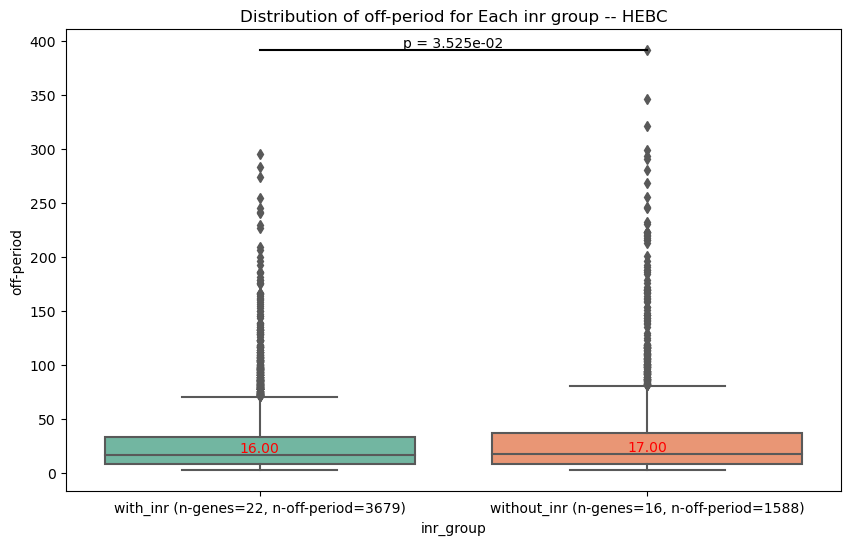

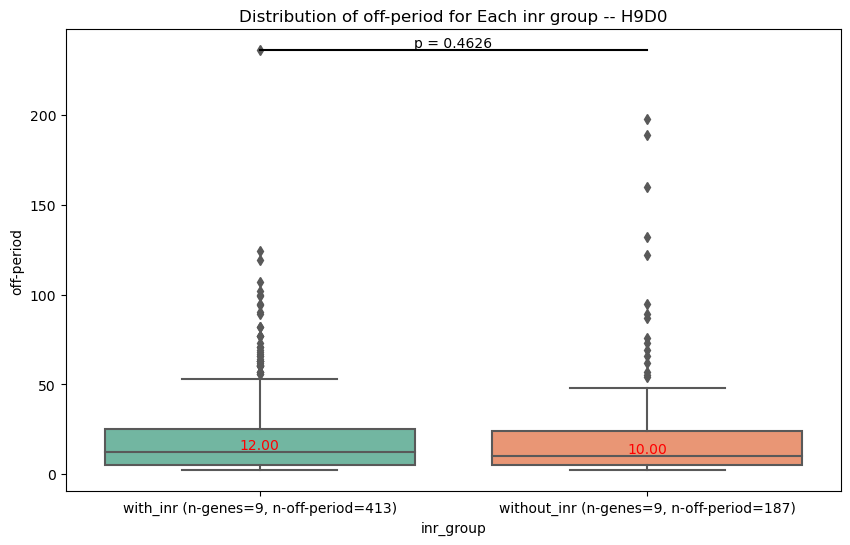

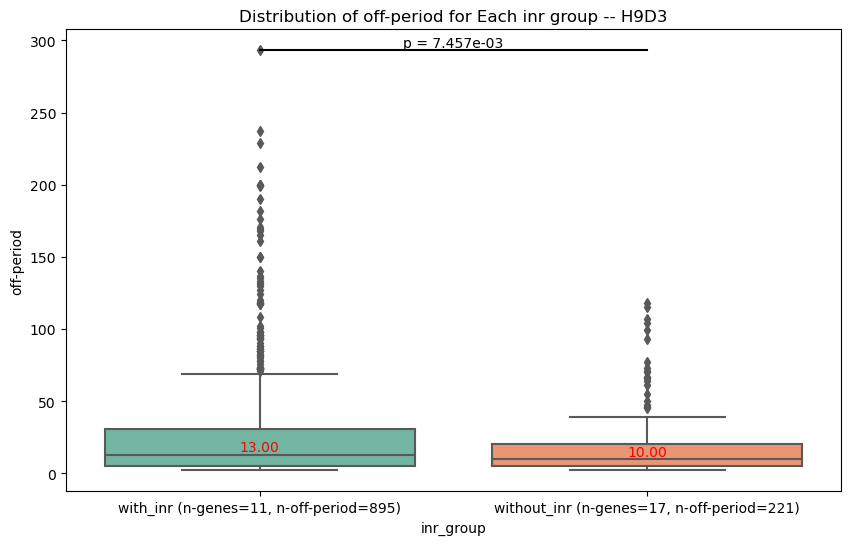

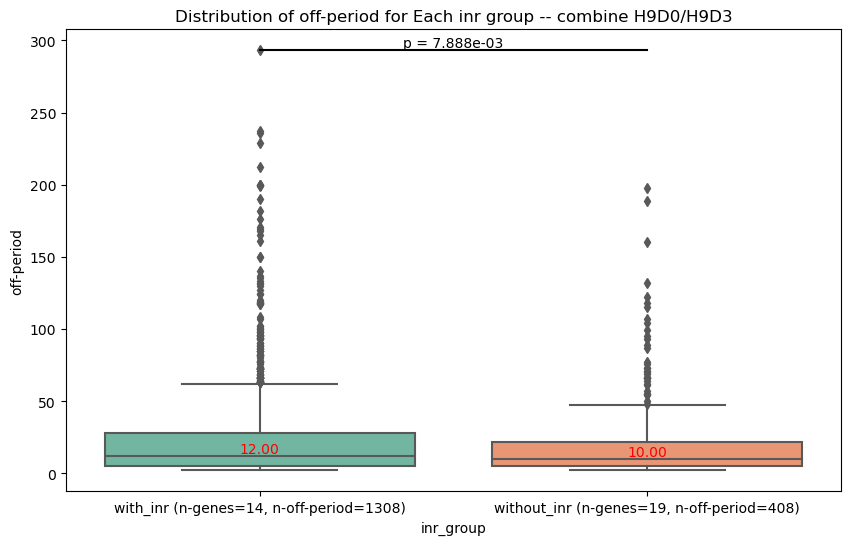

In [10]:
def plot_inr(data,  title, col = 'off-period'):

    order = ['with_inr', 'without_inr']

    # plt.figure(figsize=(10, 6))
    # sns.violinplot(x="inr_group", y=col, data=data, palette="Set2", order=order)
    # sns.stripplot(x="inr_group", y=col, data=data, color='black', size=3, jitter=True, order=order)
    # plt.title(title)
    # plt.ylabel(col)
    # plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x="inr_group", y=col, data=data, palette="Set2", order=order)
    plt.title(title )
    plt.ylabel(col);
    mean_values = data.groupby('inr_group')[col].median()
    gene_counts = data.groupby('inr_group')['gene'].nunique()
    off_period_counts = data.groupby('inr_group').size()
    new_labels = [f'{o} (n-genes={gene_counts[o]}, n-off-period={off_period_counts[o]})' for o in order]
    plt.xticks(ticks=range(len(new_labels)), labels=new_labels)
    for i, label in enumerate(order):
        plt.text(i, mean_values[label], f'{mean_values[label]:.2f}', ha='center', va='bottom', color='red')

    d1 = data[data['inr_group'] == 'with_inr'][col]
    d2 = data[data['inr_group'] == 'without_inr'][col]
    stat, p = mannwhitneyu(d1, d2)
    # Annotate plot with the significance level
    x1, x2 = 0, 1  # x coordinates for the two categories you're comparing
    y, h, color = data[col].max() , 1, 'k'  # y position and height for the line, and color
    plt.plot([x1, x2], [y, y], lw=1.5, c=color)
    plt.text((x1+x2)*.5, y,  f'p = {p:.3e}' if p < 0.05 else f'p = {p:.4f}', ha='center', va='bottom', color=color)

    plt.show()
    
data = df_off[df_off["inr_group"] != "unknown"]
plot_inr(data, f'Distribution of off-period for Each inr group -- combine HEBC/H9D0/H9D3')
plot_inr(data[data.celltype=="HBEC"], f'Distribution of off-period for Each inr group -- HEBC')
plot_inr(data[data.celltype=="H9D0"], f'Distribution of off-period for Each inr group -- H9D0')
plot_inr(data[data.celltype=="H9D3"], f'Distribution of off-period for Each inr group -- H9D3')
plot_inr(data[data.celltype!="HBEC"], f'Distribution of off-period for Each inr group -- combine H9D0/H9D3')

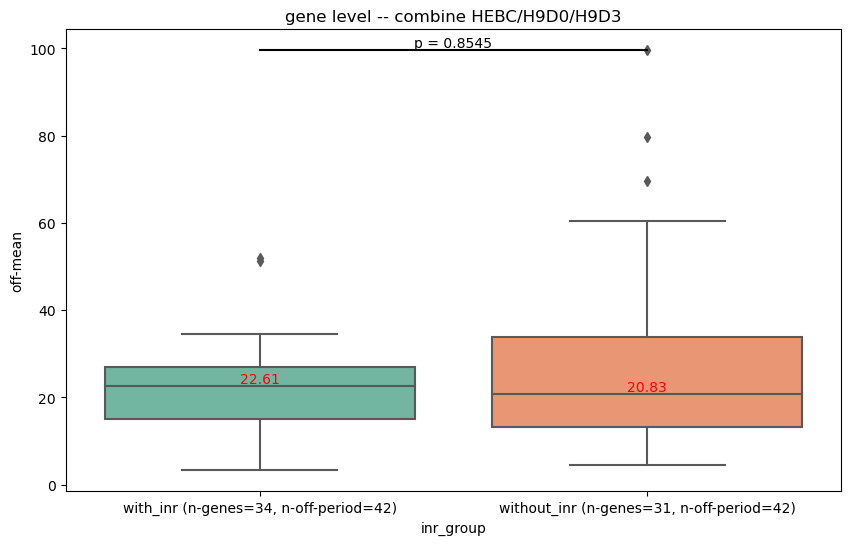

In [29]:
plot_inr(df, f'gene level -- combine HEBC/H9D0/H9D3', col = 'off-mean')

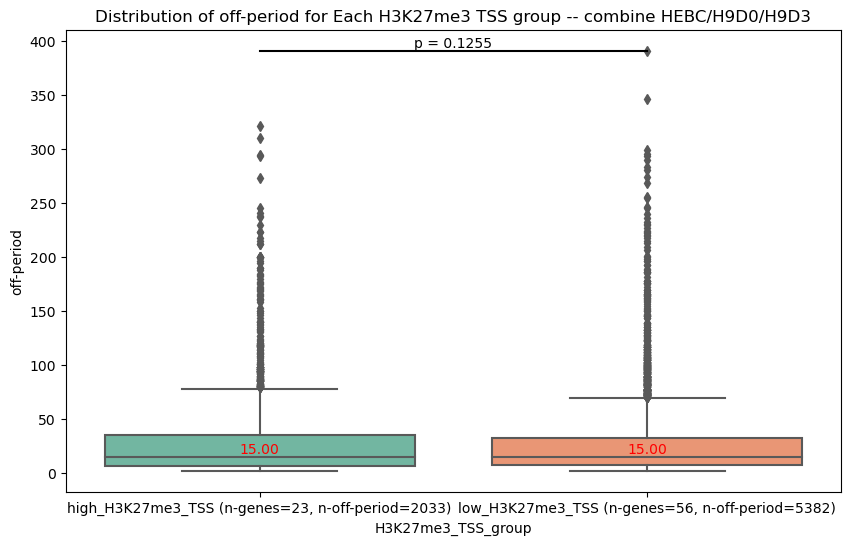

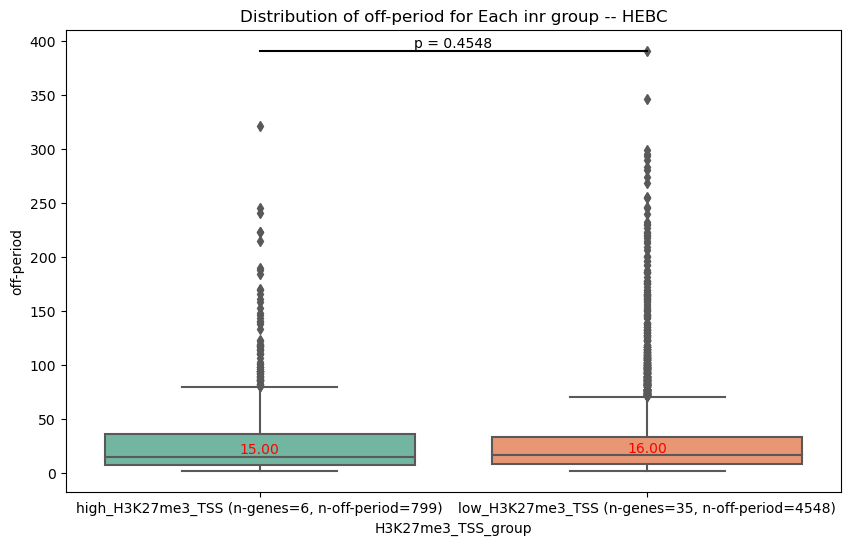

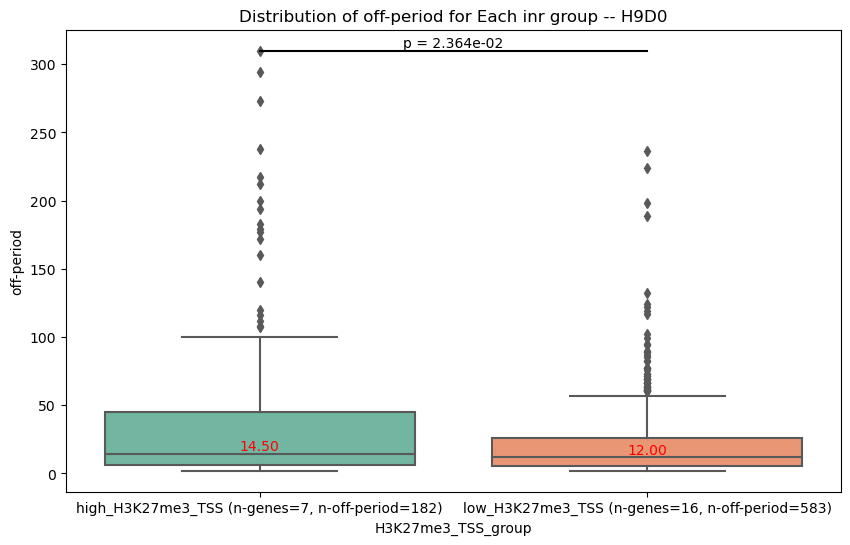

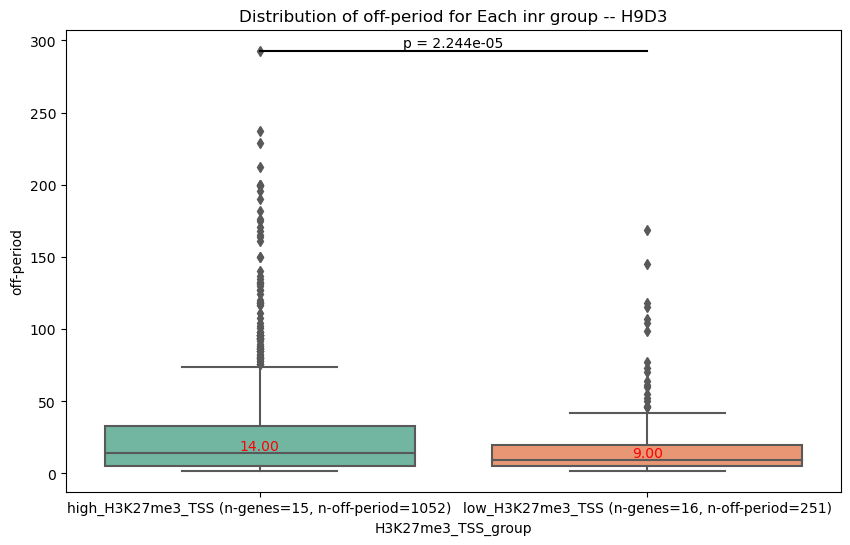

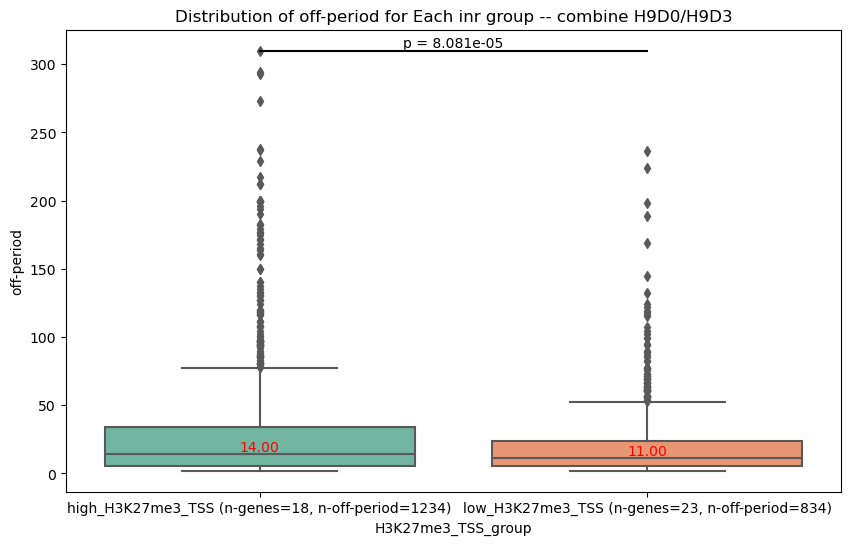

In [23]:
def plot_inr(data,  title, col = 'off-period'):

    order = ['high_H3K27me3_TSS', 'low_H3K27me3_TSS']


    data['H3K27me3_TSS_group'] = data.apply(lambda row: 'high_H3K27me3_TSS' if row['H3K27me3_tss'] > 0.5
                                       else 'low_H3K27me3_TSS', axis=1)
    

    plt.figure(figsize=(10, 6))
    sns.boxplot(x="H3K27me3_TSS_group", y=col, data=data, palette="Set2", order=order)
    plt.title(title )
    plt.ylabel(col);
    mean_values = data.groupby('H3K27me3_TSS_group')[col].median()
    gene_counts = data.groupby('H3K27me3_TSS_group')['gene'].nunique()
    off_period_counts = data.groupby('H3K27me3_TSS_group').size()
    new_labels = [f'{o} (n-genes={gene_counts[o]}, n-off-period={off_period_counts[o]})' for o in order]
    plt.xticks(ticks=range(len(new_labels)), labels=new_labels)
    for i, label in enumerate(order):
        plt.text(i, mean_values[label], f'{mean_values[label]:.2f}', ha='center', va='bottom', color='red')

    d1 = data[data['H3K27me3_TSS_group'] == 'high_H3K27me3_TSS'][col]
    d2 = data[data['H3K27me3_TSS_group'] == 'low_H3K27me3_TSS'][col]
    stat, p = mannwhitneyu(d1, d2)
    # Annotate plot with the significance level
    x1, x2 = 0, 1  # x coordinates for the two categories you're comparing
    y, h, color = data[col].max() , 1, 'k'  # y position and height for the line, and color
    plt.plot([x1, x2], [y, y], lw=1.5, c=color)
    plt.text((x1+x2)*.5, y,  f'p = {p:.3e}' if p < 0.05 else f'p = {p:.4f}', ha='center', va='bottom', color=color)

    plt.show()
    
data = df_off
plot_inr(data, f'Distribution of off-period for Each H3K27me3 TSS group -- combine HEBC/H9D0/H9D3')
plot_inr(data[data.celltype=="HBEC"], f'Distribution of off-period for Each inr group -- HEBC')
plot_inr(data[data.celltype=="H9D0"], f'Distribution of off-period for Each inr group -- H9D0')
plot_inr(data[data.celltype=="H9D3"], f'Distribution of off-period for Each inr group -- H9D3')
plot_inr(data[data.celltype!="HBEC"], f'Distribution of off-period for Each inr group -- combine H9D0/H9D3')